In [27]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score,precision_score, recall_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# setup
# Paths to data splits
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/val"
TEST_DIR = "../data/test"

# Image parameters
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 10

# Number of classes (will detect automatically)
classes = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(classes)

print(f"Detected classes: {classes}")

Detected classes: ['normal', 'yawn']


Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


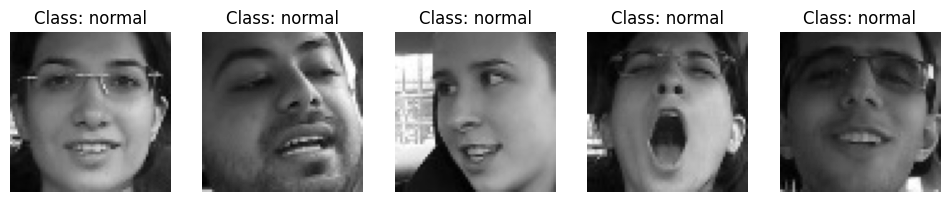

In [8]:
# Load images with ImageDataGenerator

# just rescale
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
train_generator.class_mode = 'binary'
val_generator.class_mode = 'binary'
test_generator.class_mode = 'binary'

# Preview a few images
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_batch[i].reshape(IMG_SIZE), cmap='gray')
    axes[i].set_title(f"Class: {classes[np.argmax(y_batch[i])]}")
    axes[i].axis('off')
plt.show()


In [9]:
# Build a binary CNN for driver drowsiness


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # single output neuron for binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the CNN

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


d:\SPU\5th s1 Lectures\Junior Project\code\mediapipe_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 361ms/step - accuracy: 0.6987 - loss: 0.5849 - precision: 0.3711 - recall: 0.0799 - val_accuracy: 0.8691 - val_loss: 0.3556 - val_precision: 0.7545 - val_recall: 0.7615
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.8694 - loss: 0.3599 - precision: 0.8181 - recall: 0.6598 - val_accuracy: 0.8889 - val_loss: 0.3219 - val_precision: 0.8810 - val_recall: 0.6789
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9037 - loss: 0.3153 - precision: 0.8767 - recall: 0.7426 - val_accuracy: 0.9086 - val_loss: 0.3176 - val_precision: 0.9000 - val_recall: 0.7431
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - accuracy: 0.9103 - loss: 0.2654 - precision: 0.8985 - recall: 0.7486 - val_accuracy: 0.9086 - val_loss: 0.3184 - val_precision: 0.8913 - val_recall: 0.7523
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.9058 - loss: 0.2697 - precision: 0.8724 - recall: 0.7389 - val_accuracy: 0.9086 - val_los

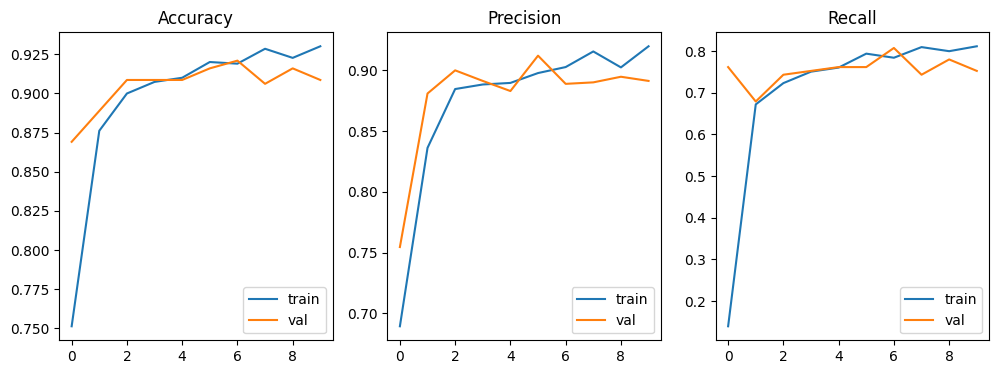

In [11]:
# Plot training history
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

# Precision
plt.subplot(1,3,2)
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='val')
plt.title('Precision')
plt.legend()

# Recall
plt.subplot(1,3,3)
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.title('Recall')
plt.legend()

plt.show()


In [ ]:
# Evaluate model on test set and compute F1 score precision and recall

# Predict on test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # threshold 0.5 for binary
y_true = test_generator.classes  # true labels

test_accuracy = np.mean(y_pred == y_true)
print(f"test accuracy score on test set: {test_accuracy:.4f}")

test_precision = precision_score(y_true, y_pred)
print(f"precision score on test set: {test_precision:.4f}")

test_recall = recall_score(y_true, y_pred)
print(f"recall score on test set: {test_recall:.4f}")

f1 = f1_score(y_true, y_pred)
print(f"F1 score on test set: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step
test accuracy score on test set: 0.9238
precision score on test set: 0.9341
recall score on test set: 0.7727
F1 score on test set: 0.8458


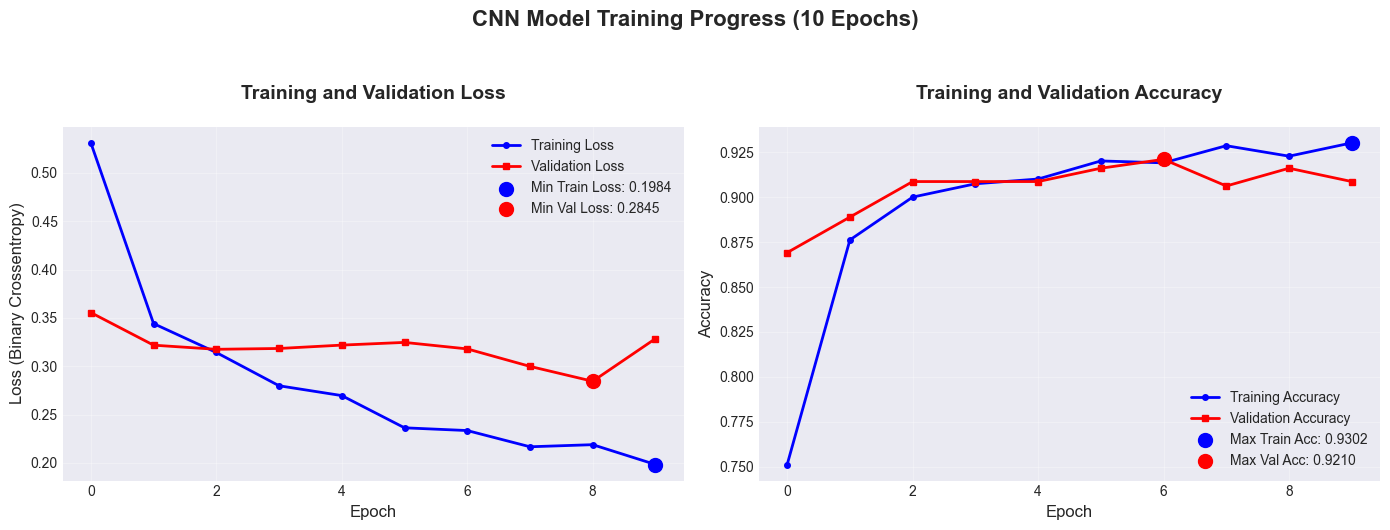

In [21]:

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')

# Plot 1: Loss Curves
plt.figure(figsize=(14, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
plt.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Binary Crossentropy)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add min loss markers
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
min_train_epoch = history.history['loss'].index(min_train_loss)
min_val_epoch = history.history['val_loss'].index(min_val_loss)

plt.scatter(min_train_epoch, min_train_loss, color='blue', s=100, zorder=5,
            label=f'Min Train Loss: {min_train_loss:.4f}')
plt.scatter(min_val_epoch, min_val_loss, color='red', s=100, zorder=5,
            label=f'Min Val Loss: {min_val_loss:.4f}')

plt.legend(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy', marker='o', markersize=4)
plt.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy', marker='s', markersize=4)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add max accuracy markers
max_train_acc = max(history.history['accuracy'])
max_val_acc = max(history.history['val_accuracy'])
max_train_epoch = history.history['accuracy'].index(max_train_acc)
max_val_epoch = history.history['val_accuracy'].index(max_val_acc)

plt.scatter(max_train_epoch, max_train_acc, color='blue', s=100, zorder=5,
            label=f'Max Train Acc: {max_train_acc:.4f}')
plt.scatter(max_val_epoch, max_val_acc, color='red', s=100, zorder=5,
            label=f'Max Val Acc: {max_val_acc:.4f}')

plt.legend(fontsize=10)

plt.suptitle('CNN Model Training Progress (10 Epochs)', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

Available metrics in history: dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])


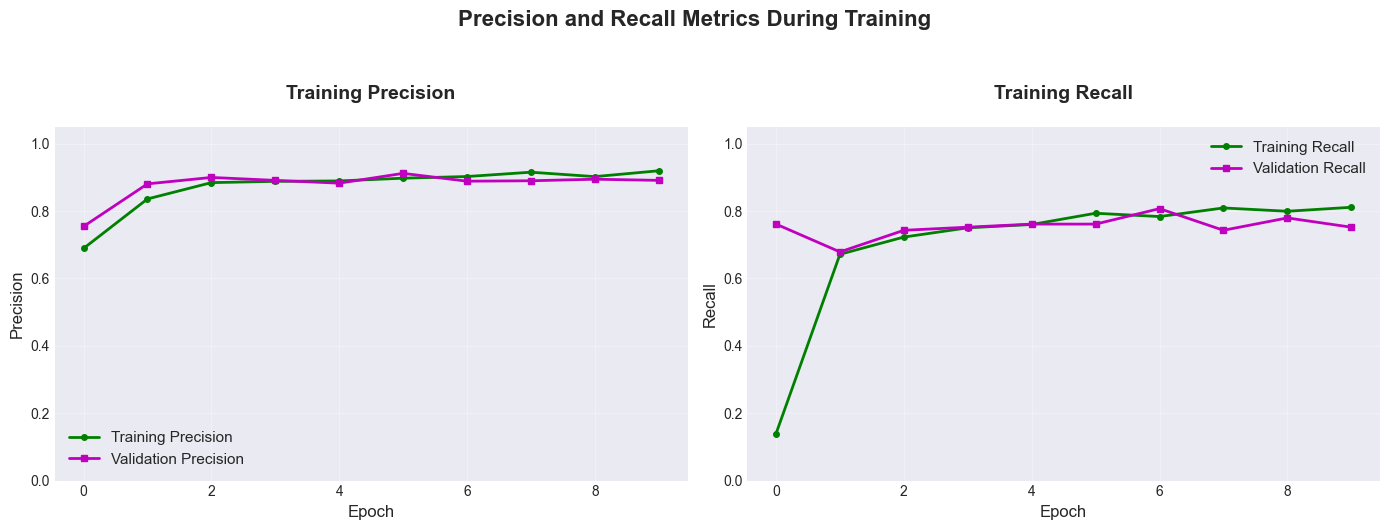

In [22]:
# Check if precision and recall are in history
print("Available metrics in history:", history.history.keys())

# If you tracked precision and recall during training:
if 'precision' in history.history and 'recall' in history.history:
    plt.figure(figsize=(14, 5))

    # Subplot 1: Precision
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], 'g-', linewidth=2, label='Training Precision', marker='o', markersize=4)
    if 'val_precision' in history.history:
        plt.plot(history.history['val_precision'], 'm-', linewidth=2, label='Validation Precision', marker='s', markersize=4)
    plt.title('Training Precision', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])

    # Subplot 2: Recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], 'g-', linewidth=2, label='Training Recall', marker='o', markersize=4)
    if 'val_recall' in history.history:
        plt.plot(history.history['val_recall'], 'm-', linewidth=2, label='Validation Recall', marker='s', markersize=4)
    plt.title('Training Recall', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1.05])

    plt.suptitle('Precision and Recall Metrics During Training', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
else:
    print("Precision and recall were not tracked during training. They were only computed during evaluation.")

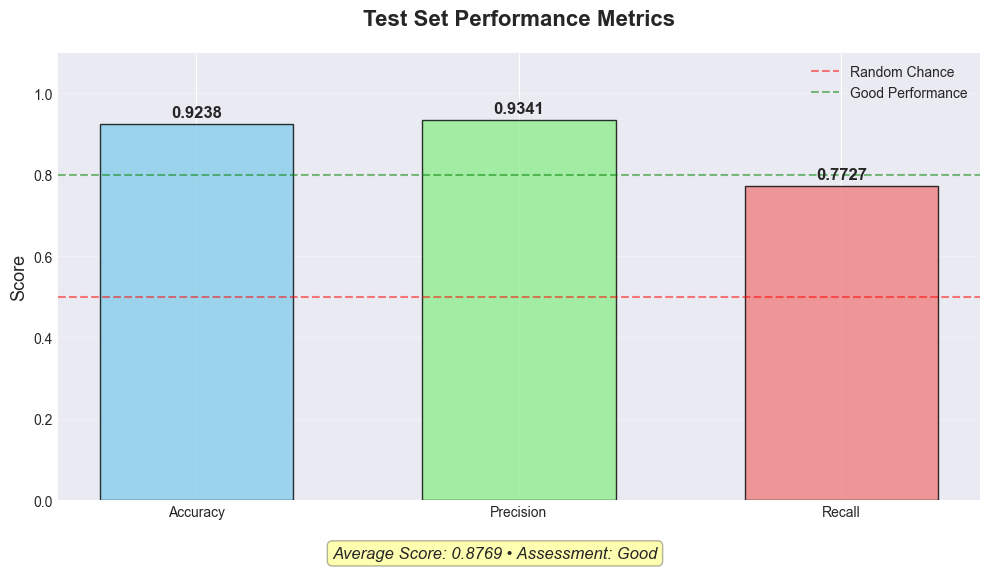

In [33]:
# Create a bar chart for test performance
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall']
values = [test_accuracy, test_precision, test_recall]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = plt.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8, width=0.6)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Test Set Performance Metrics', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=13)
plt.ylim([0, 1.1])
plt.grid(axis='y', alpha=0.3)

# Add horizontal line at 0.5 for reference
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Chance')
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Good Performance')
plt.legend()

# Add text annotation with overall assessment
avg_score = np.mean(values)
assessment = "Excellent" if avg_score > 0.9 else "Good" if avg_score > 0.8 else "Fair" if avg_score > 0.7 else "Needs Improvement"
plt.figtext(0.5, 0.01, f'Average Score: {avg_score:.4f} • Assessment: {assessment}',
            ha='center', fontsize=12, style='italic',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

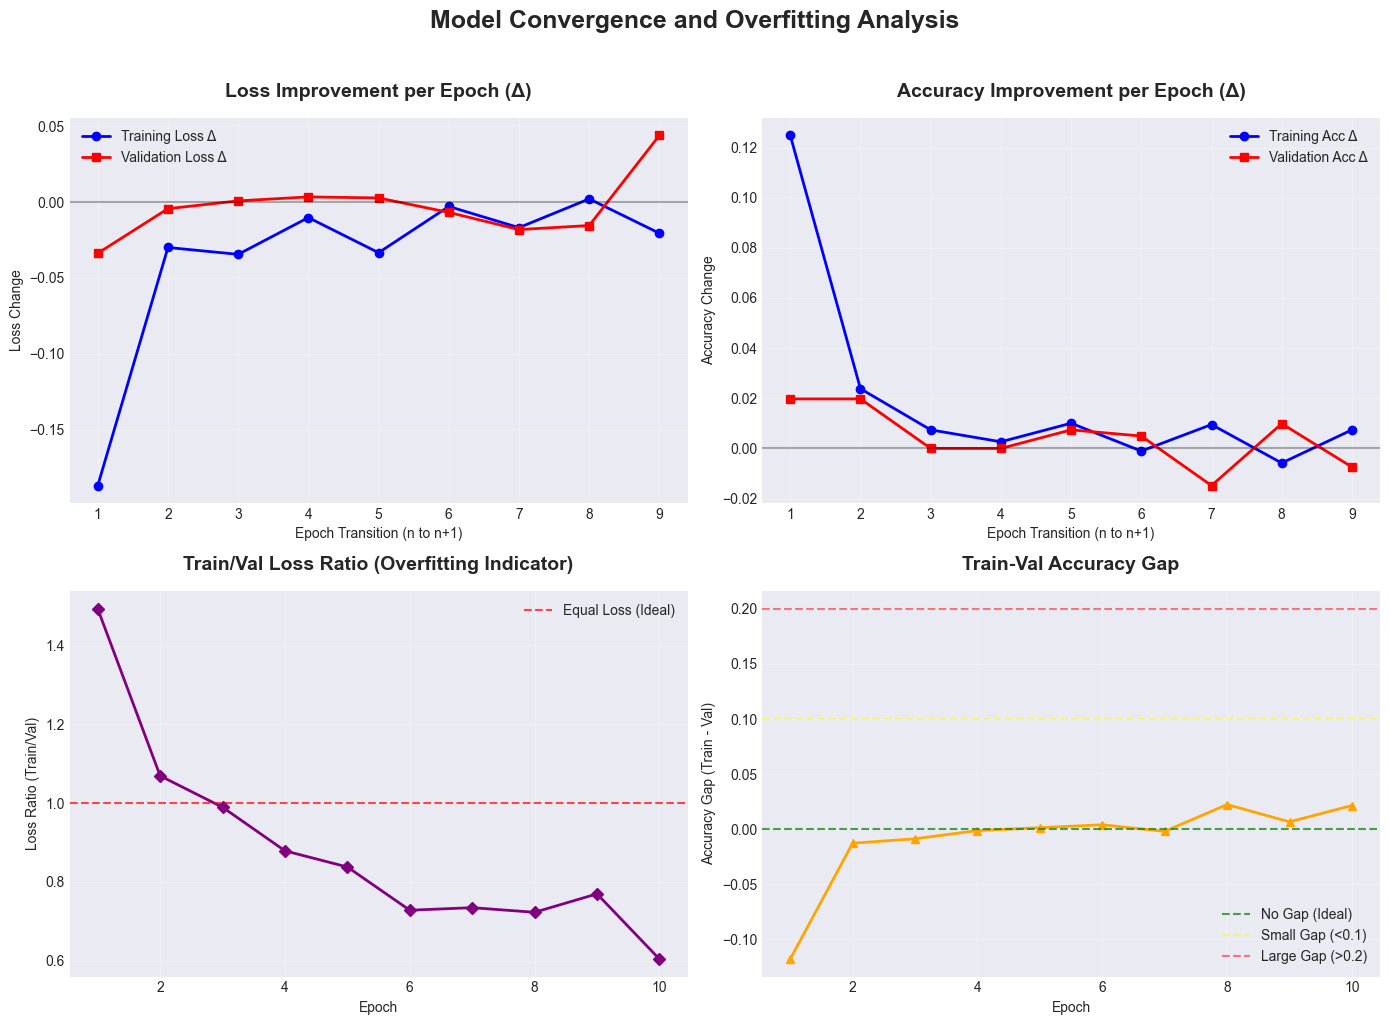

In [34]:
# Analyze convergence by looking at differences between epochs
plt.figure(figsize=(14, 10))
epochs = 10

# Calculate differences between consecutive epochs
train_loss_diff = np.diff(history.history['loss'])
val_loss_diff = np.diff(history.history['val_loss'])
train_acc_diff = np.diff(history.history['accuracy'])
val_acc_diff = np.diff(history.history['val_accuracy'])

epochs_diff = range(1, epochs)  # One less epoch for differences

# Subplot 1: Loss differences (convergence rate)
plt.subplot(2, 2, 1)
plt.plot(epochs_diff, train_loss_diff, 'b-', linewidth=2, label='Training Loss Δ', marker='o')
plt.plot(epochs_diff, val_loss_diff, 'r-', linewidth=2, label='Validation Loss Δ', marker='s')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Loss Improvement per Epoch (Δ)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch Transition (n to n+1)')
plt.ylabel('Loss Change')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Accuracy differences
plt.subplot(2, 2, 2)
plt.plot(epochs_diff, train_acc_diff, 'b-', linewidth=2, label='Training Acc Δ', marker='o')
plt.plot(epochs_diff, val_acc_diff, 'r-', linewidth=2, label='Validation Acc Δ', marker='s')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Accuracy Improvement per Epoch (Δ)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch Transition (n to n+1)')
plt.ylabel('Accuracy Change')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Loss ratio (train/val) - Overfitting indicator
plt.subplot(2, 2, 3)
loss_ratio = [t/v if v != 0 else 0 for t, v in zip(history.history['loss'], history.history['val_loss'])]
plt.plot(range(1, epochs+1), loss_ratio, color='purple', linewidth=2, marker='D')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Equal Loss (Ideal)')
plt.title('Train/Val Loss Ratio (Overfitting Indicator)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Loss Ratio (Train/Val)')
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 4: Gap between train and validation accuracy
plt.subplot(2, 2, 4)
acc_gap = [t - v for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
plt.plot(range(1, epochs+1), acc_gap, color='orange', linewidth=2, marker='^')
plt.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='No Gap (Ideal)')
plt.axhline(y=0.1, color='yellow', linestyle='--', alpha=0.5, label='Small Gap (<0.1)')
plt.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Large Gap (>0.2)')
plt.title('Train-Val Accuracy Gap', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (Train - Val)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.suptitle('Model Convergence and Overfitting Analysis', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [19]:
#  full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))



Classification Report:
              precision    recall  f1-score   support

      normal       0.92      0.98      0.95       297
        yawn       0.93      0.77      0.85       110

    accuracy                           0.92       407
   macro avg       0.93      0.88      0.90       407
weighted avg       0.92      0.92      0.92       407



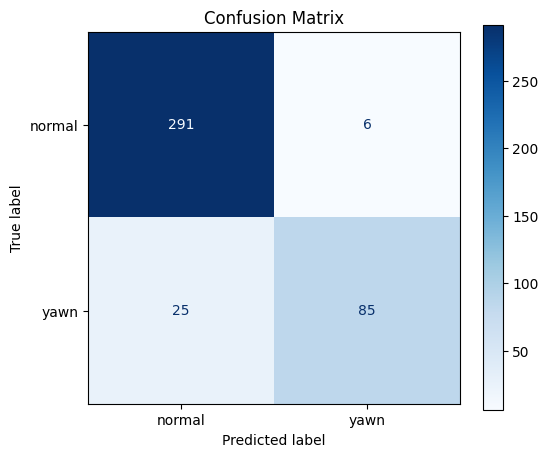

In [20]:
# Plot confusion matrix 

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


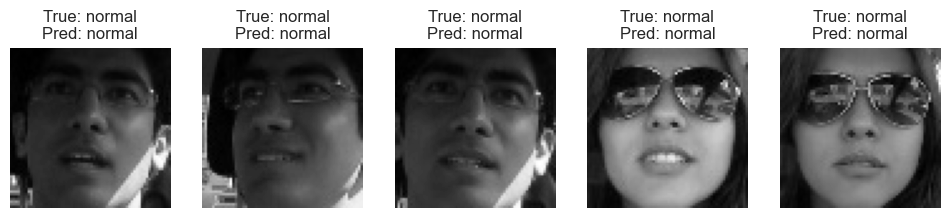

In [39]:
# Sample Predictions – display test images with predicted vs true labels
x_test, y_test = next(test_generator)  # batch from test generator
y_pred_sample = (model.predict(x_test) > 0.5).astype(int).reshape(-1)

# Convert true labels to integers
y_test_int = y_test.astype(int)

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    axes[i].imshow(x_test[i].reshape(IMG_SIZE), cmap='gray')
    axes[i].set_title(f"True: {classes[y_test_int[i]]}\nPred: {classes[y_pred_sample[i]]}")
    axes[i].axis('off')
plt.show()


In [40]:
# Save the model (architecture + weights + optimizer state)
model.save("../models/driver_drowsiness_cnn1.h5")  # .h5 format

In [42]:
import pickle

with open("../models/training_history1.pkl", "wb") as f:
    pickle.dump(history.history, f)

# how to load -->
# with open("../models/training_history.pkl", "rb") as f:
#     history = pickle.load(f)
